#### Import Modules and Read Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# for hopkins statistics
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

# feature scaling
from sklearn.preprocessing import StandardScaler

# for k means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# for hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

plt.style.use('ggplot')

In [2]:
country_df = pd.read_csv('Country-data.csv')
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [ ]:
country_df.info()

In [3]:
country_df[['exports','health','imports']] = country_df[['exports','health','imports']].apply(lambda x : x*country_df['gdpp']/100)
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [ ]:
country_df.describe()

#### Data Visualization

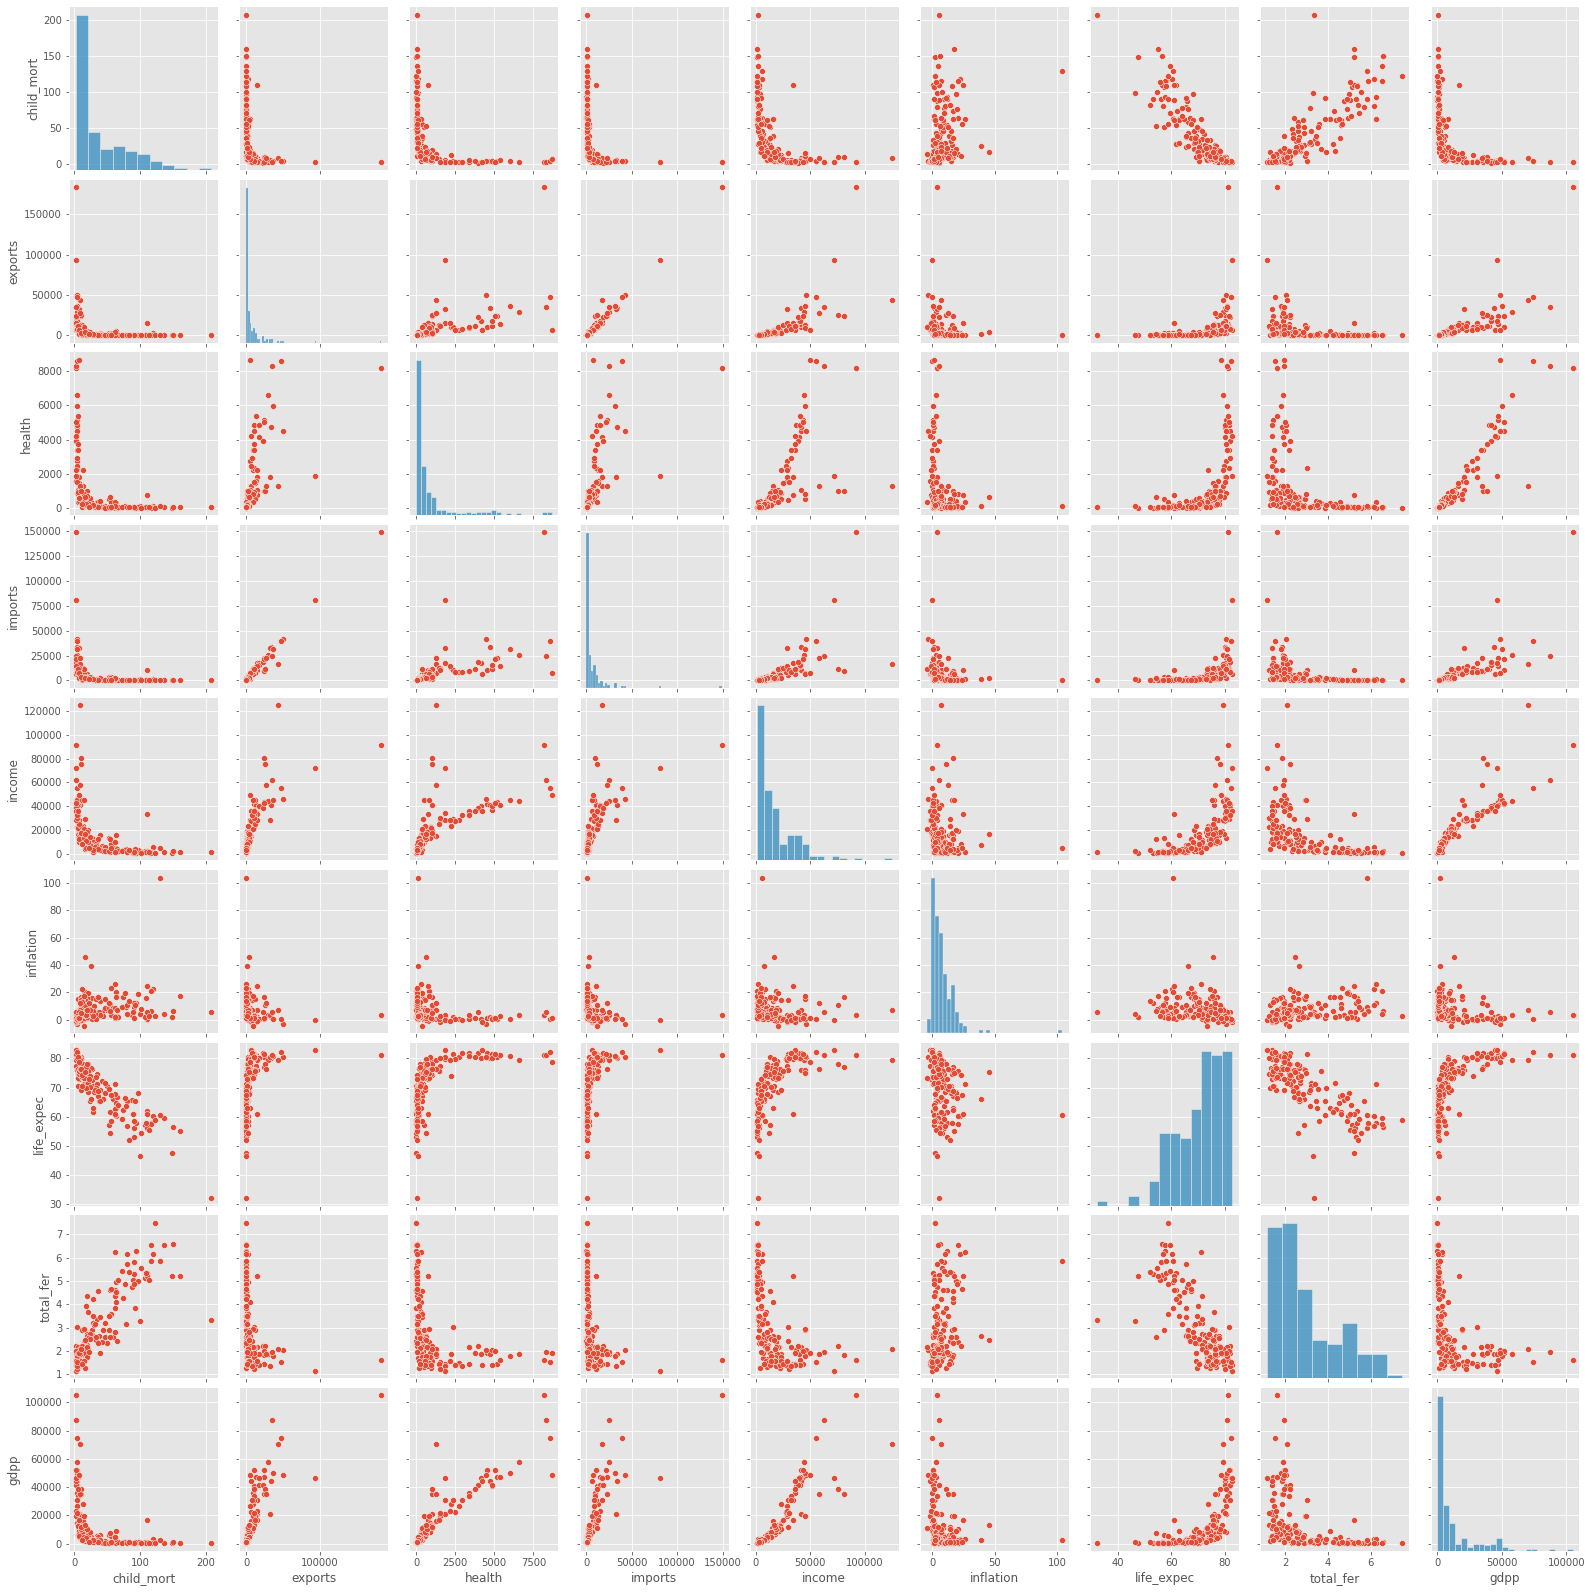

In [4]:
# bivariate analysis

sns.pairplot(country_df)
plt.show()

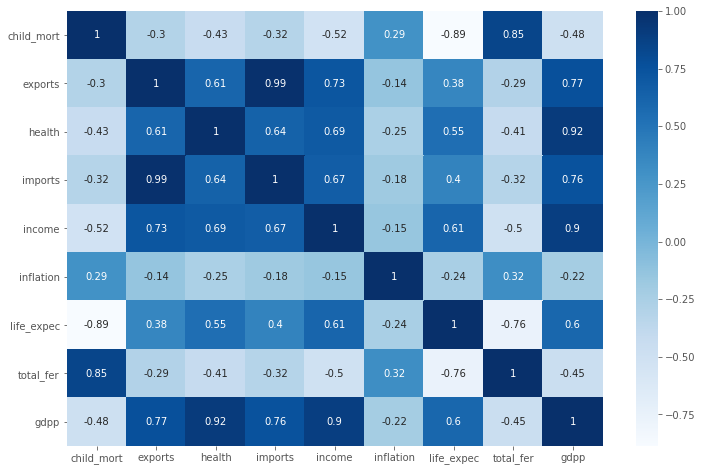

In [4]:
plt.figure(figsize=(12,8))
sns.heatmap(country_df.corr(),annot=True,cmap='Blues')
plt.show()

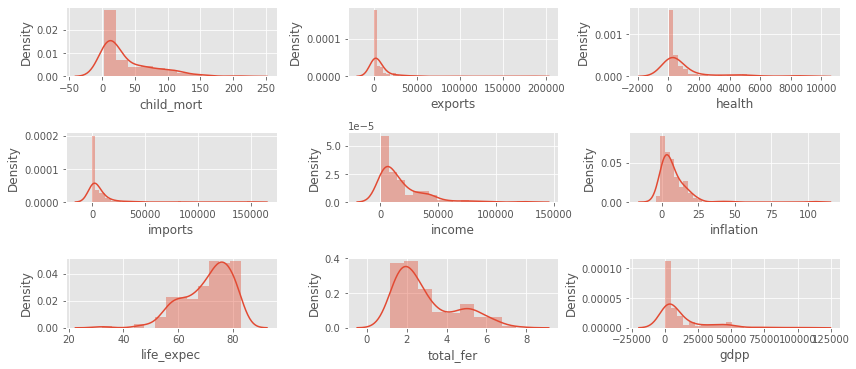

In [7]:
# univariate analysis
fig = plt.subplots(figsize=(12, 10))

for i,feature in enumerate(country_df.drop('country', axis=1).columns):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace= 2.0)
    sns.distplot(country_df[feature])
    plt.tight_layout()

#### Handling Outliers

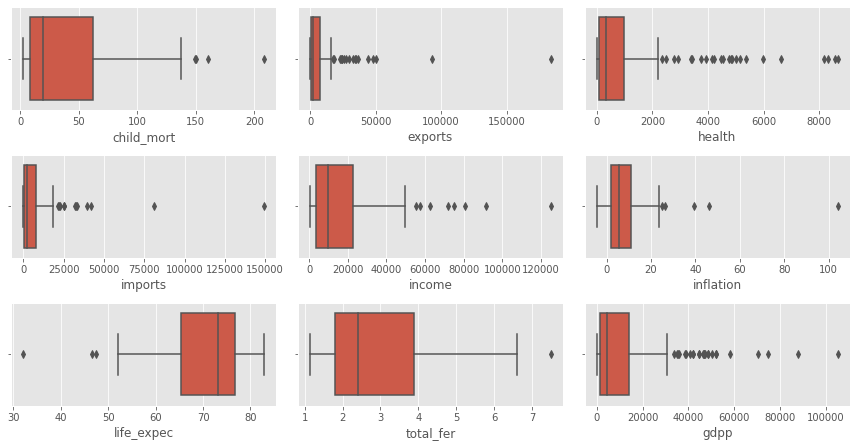

In [11]:
fig = plt.subplots(figsize=(12, 12))

for i, feature in enumerate(country_df.drop('country', axis=1).columns):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace = 2.0)
    sns.boxplot(country_df[feature])
    plt.savefig('boxplot_of_numerical_features.png')
    plt.tight_layout()

In [4]:
country_df_updated = country_df.iloc[:,:]

def outliers_for_features(country_df, col):
    Q1 = country_df.loc[:,col].quantile(0.25)
    Q3 = country_df.loc[:,col].quantile(0.75)

    upper_limit = Q3 + 1.5*(Q3-Q1)
    lower_limit = Q1 - 1.5*(Q3-Q1)

    return country_df_updated[col].apply(lambda x: upper_limit if x > upper_limit else lower_limit if x < lower_limit else x)
for col in ['life_expec','inflation','total_fer','exports','imports','health','income','gdpp']:
     country_df_updated[col] = outliers_for_features(country_df, col)

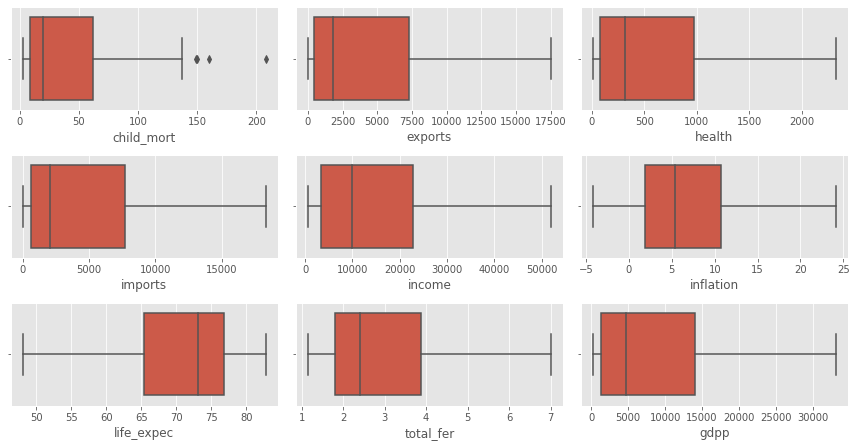

In [5]:
# checking the distribution after flooring and capping
fig = plt.subplots(figsize=(12, 12))

for i, feature in enumerate(country_df_updated.drop('country', axis=1).columns):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace= 2.0)
    sns.boxplot(country_df_updated[feature])
    plt.tight_layout()

In [18]:
country_df_updated

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,1384.02,155.9250,1565.190,2950.0,2.62,63.0,3.50,2970.0
163,Venezuela,17.1,3847.50,662.8500,2376.000,16500.0,24.16,75.4,2.47,13500.0
164,Vietnam,23.3,943.20,89.6040,1050.620,4490.0,12.10,73.1,1.95,1310.0
165,Yemen,56.3,393.00,67.8580,450.640,4480.0,23.60,67.5,4.67,1310.0


#### Checking Suitability of dataset for clustering, Hopkins test

In [6]:
def hopkins(X):
    d = X.shape[1]
    # d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0), np.amax(X, axis=0), d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd)/(sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
    return H

In [8]:
hopkins(country_df.drop('country', axis = 1))

0.8745048249715519

In [9]:
hopkins(country_df_updated.drop('country', axis = 1))

0.9043458687753599

#### Scaling the data

In [6]:
standard_scaler = StandardScaler()
country_df_scaled = standard_scaler.fit_transform(country_df_updated.iloc[:,1:])

#### Clustering

#### K Means

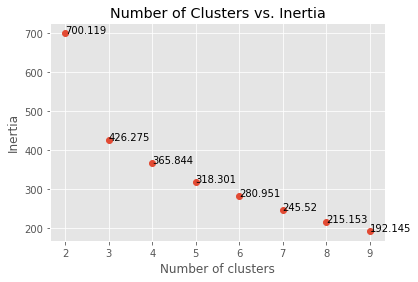

In [7]:
# choosing k-value for kmeans algorithm
ssd = []
num_of_clusters = list(range(2,10))
for n in num_of_clusters:
    km = KMeans(n_clusters= n, max_iter= 50, random_state=101).fit(country_df_scaled)
    ssd.append(km.inertia_)
plt.plot(num_of_clusters, ssd, linestyle='None', marker='o')

for xy in zip(num_of_clusters, ssd):
    plt.annotate(s = round(xy[1],3), xy = xy, textcoords='data')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia") # Inertia is within cluster sum of squares
plt.title("Number of Clusters vs. Inertia")
plt.savefig('inertia.png')
plt.show()

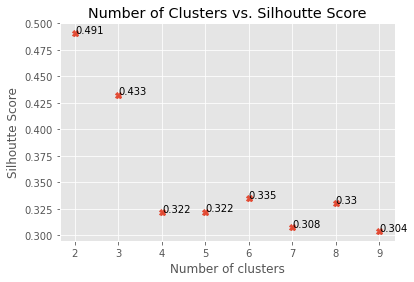

In [8]:
silhouette_value = []
for n in range(2,10):
    km = KMeans(n_clusters= n, random_state=101).fit(country_df_scaled)
    silhouette_value.append(silhouette_score(country_df_scaled, km.labels_))
plt.plot(num_of_clusters, silhouette_value, linestyle='None', marker='X', label=silhouette_value)
plt.xlabel("Number of clusters")
plt.ylabel("Silhoutte Score")
plt.title("Number of Clusters vs. Silhoutte Score")

for xy in zip(num_of_clusters, silhouette_value):
    plt.annotate(s = round(xy[1],3), xy=xy, textcoords='data')
plt.savefig('silhouette.png')
plt.show()

In [7]:
# building k means model with 3 clusters
km = KMeans(n_clusters=3, max_iter=100, random_state= 101)
km.fit(country_df_scaled)

KMeans(max_iter=100, n_clusters=3, random_state=101)

In [12]:
print(km.labels_)
print(km.labels_.shape)

[1 2 2 1 2 2 2 0 0 2 0 0 2 2 2 0 2 1 2 2 2 2 2 0 2 1 1 2 1 0 2 1 1 2 2 2 1
 1 1 2 1 2 0 0 0 2 2 2 2 1 1 0 2 0 0 1 1 2 0 1 0 2 2 1 1 2 1 0 0 2 2 2 1 0
 0 0 2 0 2 2 1 1 0 2 1 2 2 1 1 2 2 0 2 1 1 2 2 1 0 1 2 2 2 2 2 2 1 2 1 2 0
 0 1 1 0 0 1 2 2 2 2 2 0 0 2 2 1 2 0 1 2 2 1 0 0 0 1 2 0 0 2 2 1 2 0 0 2 1
 2 1 1 2 2 2 2 1 2 0 0 0 2 2 2 2 2 1 1]
(167,)


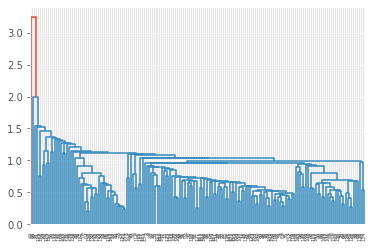

In [8]:
# Hierarchical Clustering
mergings_single = linkage(country_df_scaled, method='single', metric='euclidean')
dendrogram(mergings_single)
plt.show()

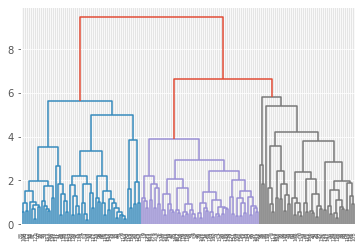

In [8]:
mergings_complete = linkage(country_df_scaled, method='complete', metric='euclidean')
dendrogram(mergings_complete)
plt.show()

In [10]:
# taking 3 clusters for hierarchical clustering
cluster_labels = cut_tree(mergings_complete, n_clusters=3).reshape(-1, )
print(cluster_labels)
print(cluster_labels.shape)

[0 1 1 0 2 1 1 2 2 1 2 2 1 2 1 2 1 0 1 1 1 0 2 2 1 0 0 1 0 2 1 0 0 2 1 1 0
 0 0 2 0 2 2 2 2 1 1 1 1 0 0 2 1 2 2 0 0 1 2 0 2 1 1 0 0 1 0 2 2 1 1 1 0 2
 2 2 1 2 1 1 0 0 2 1 0 2 2 0 0 2 2 2 1 0 0 2 2 0 2 0 1 1 1 1 2 1 0 1 0 1 2
 2 0 0 2 2 0 2 1 1 1 2 2 2 1 1 0 1 2 0 1 2 0 2 2 2 0 0 2 2 1 1 0 2 2 2 1 0
 1 0 0 1 1 2 1 0 1 2 2 2 2 1 1 1 1 0 0]
(167,)


In [11]:
country_df_clustered = country_df_updated.iloc[:,:]
country_df_clustered = pd.concat([country_df_clustered, pd.DataFrame(km.labels_, columns=['cluster_id_km'])], axis = 1)
country_df_clustered = pd.concat([country_df_clustered, pd.DataFrame(cluster_labels, columns=['cluster_id_hc'])], axis = 1)
country_df_clustered.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id_km,cluster_id_hc
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,1,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,1,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2,2


In [12]:
print(country_df_clustered['cluster_id_km'].value_counts())
print(country_df_clustered['cluster_id_hc'].value_counts())

2    80
1    46
0    41
Name: cluster_id_km, dtype: int64
2    60
1    59
0    48
Name: cluster_id_hc, dtype: int64


In [13]:
print("Cluster 0 of Hierarchical Clustering model")
print(country_df_clustered[country_df_clustered['cluster_id_hc'] == 0].country.unique())

print("Cluster 1 of Hierarchical Clustering model")
print(country_df_clustered[country_df_clustered['cluster_id_hc'] == 1].country.unique())

print("Cluster 2 of Hierarchical Clustering model")
print(country_df_clustered[country_df_clustered['cluster_id_hc'] == 2].country.unique())

Cluster 0 of Hierarchical Clustering model
['Afghanistan' 'Angola' 'Benin' 'Botswana' 'Burkina Faso' 'Burundi'
 'Cameroon' 'Central African Republic' 'Chad' 'Comoros' 'Congo, Dem. Rep.'
 'Congo, Rep.' "Cote d'Ivoire" 'Equatorial Guinea' 'Eritrea' 'Gabon'
 'Gambia' 'Ghana' 'Guinea' 'Guinea-Bissau' 'Haiti' 'Iraq' 'Kenya'
 'Kiribati' 'Lao' 'Lesotho' 'Liberia' 'Madagascar' 'Malawi' 'Mali'
 'Mauritania' 'Mozambique' 'Namibia' 'Niger' 'Nigeria' 'Pakistan' 'Rwanda'
 'Senegal' 'Sierra Leone' 'Solomon Islands' 'South Africa' 'Sudan'
 'Tanzania' 'Timor-Leste' 'Togo' 'Uganda' 'Yemen' 'Zambia']
Cluster 1 of Hierarchical Clustering model
['Albania' 'Algeria' 'Argentina' 'Armenia' 'Azerbaijan' 'Bangladesh'
 'Belarus' 'Belize' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Bulgaria'
 'Cambodia' 'Cape Verde' 'China' 'Colombia' 'Dominican Republic' 'Ecuador'
 'Egypt' 'El Salvador' 'Fiji' 'Georgia' 'Grenada' 'Guatemala' 'Guyana'
 'India' 'Indonesia' 'Iran' 'Jamaica' 'Jordan' 'Kazakhstan'
 'Kyrgyz Republic

In [14]:
print("Cluster 0 of KMeans model")
print(country_df_clustered[country_df_clustered['cluster_id_km'] == 0].country.unique())

print("Cluster 1 of Kmeans model")
print(country_df_clustered[country_df_clustered['cluster_id_km'] == 1].country.unique())

print("Cluster 2 of Kmeans model")
print(country_df_clustered[country_df_clustered['cluster_id_km'] == 2].country.unique())

Cluster 0 of KMeans model
['Australia' 'Austria' 'Bahamas' 'Bahrain' 'Belgium' 'Brunei' 'Canada'
 'Cyprus' 'Czech Republic' 'Denmark' 'Estonia' 'Finland' 'France'
 'Germany' 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Israel' 'Italy' 'Japan'
 'Kuwait' 'Luxembourg' 'Malta' 'Netherlands' 'New Zealand' 'Norway' 'Oman'
 'Portugal' 'Qatar' 'Saudi Arabia' 'Singapore' 'Slovak Republic'
 'Slovenia' 'South Korea' 'Spain' 'Sweden' 'Switzerland'
 'United Arab Emirates' 'United Kingdom' 'United States']
Cluster 1 of Kmeans model
['Afghanistan' 'Angola' 'Benin' 'Burkina Faso' 'Burundi' 'Cameroon'
 'Central African Republic' 'Chad' 'Comoros' 'Congo, Dem. Rep.'
 'Congo, Rep.' "Cote d'Ivoire" 'Equatorial Guinea' 'Eritrea' 'Gabon'
 'Gambia' 'Ghana' 'Guinea' 'Guinea-Bissau' 'Haiti' 'Iraq' 'Kenya'
 'Kiribati' 'Lao' 'Lesotho' 'Liberia' 'Madagascar' 'Malawi' 'Mali'
 'Mauritania' 'Mozambique' 'Namibia' 'Niger' 'Nigeria' 'Pakistan' 'Rwanda'
 'Senegal' 'Sierra Leone' 'Solomon Islands' 'Sudan' 'Tanzania'
 'Timor-L

#### Cluster Profiling

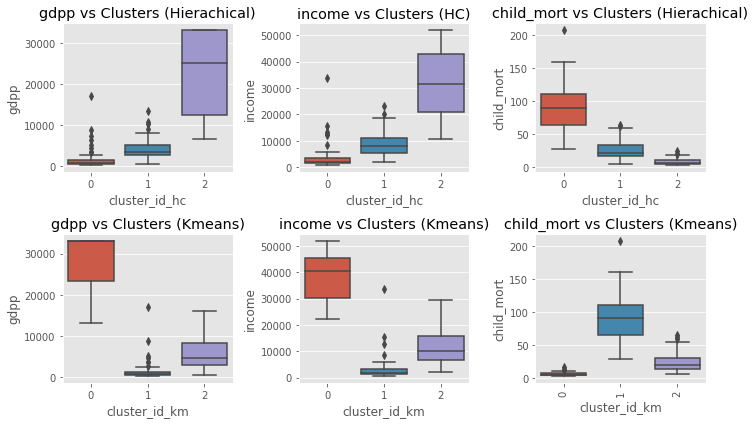

In [13]:
fig  = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(2, 3, 1, title="gdpp vs Clusters (Hierachical)")
ax4 = fig.add_subplot(2, 3, 4, title="gdpp vs Clusters (Kmeans)")

ax2 = fig.add_subplot(2, 3, 2, title="income vs Clusters (HC)")
ax5 = fig.add_subplot(2, 3, 5, title="income vs Clusters (Kmeans)")

ax3 = fig.add_subplot(2, 3, 3, title="child_mort vs Clusters (Hierachical)")
ax6 = fig.add_subplot(2, 3, 6, title="child_mort vs Clusters (Kmeans)")

sns.boxplot(country_df_clustered['cluster_id_hc'], country_df_clustered['gdpp'], ax=ax1)
sns.boxplot(country_df_clustered['cluster_id_km'], country_df_clustered['gdpp'], ax=ax4)

sns.boxplot(country_df_clustered['cluster_id_hc'], country_df_clustered['income'], ax=ax2)
sns.boxplot(country_df_clustered['cluster_id_km'], country_df_clustered['income'], ax=ax5)

sns.boxplot(country_df_clustered['cluster_id_hc'], country_df_clustered['child_mort'], ax=ax3)
sns.boxplot(country_df_clustered['cluster_id_km'], country_df_clustered['child_mort'], ax=ax6)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


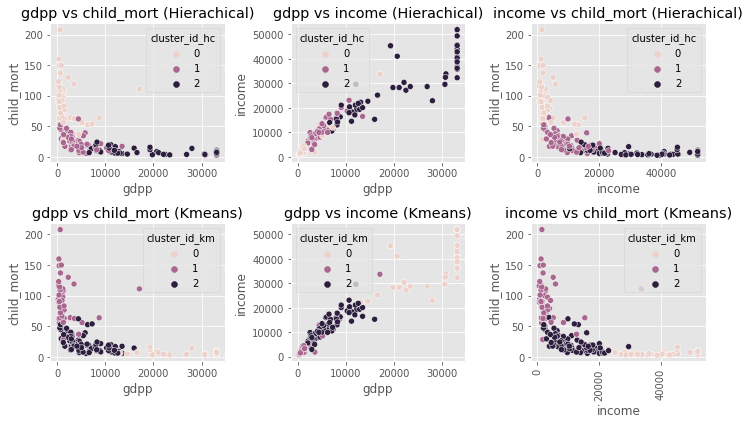

In [12]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(2, 3, 1, title="gdpp vs child_mort (Hierachical)")
ax4 = fig.add_subplot(2, 3, 4, title="gdpp vs child_mort (Kmeans)")

ax2 = fig.add_subplot(2, 3, 2, title="gdpp vs income (Hierachical)")
ax5 = fig.add_subplot(2, 3, 5, title="gdpp vs income (Kmeans)")

ax3 = fig.add_subplot(2, 3, 3, title="income vs child_mort (Hierachical)")
ax6 = fig.add_subplot(2, 3, 6, title="income vs child_mort (Kmeans)")

sns.scatterplot(country_df_clustered['gdpp'],country_df_clustered['child_mort'], hue=country_df_clustered['cluster_id_hc'], ax=ax1)
sns.scatterplot(country_df_clustered['gdpp'],country_df_clustered['child_mort'], hue=country_df_clustered['cluster_id_km'], ax=ax4)

sns.scatterplot(country_df_clustered['gdpp'],country_df_clustered['income'], hue=country_df_clustered['cluster_id_hc'], ax=ax2)
sns.scatterplot(country_df_clustered['gdpp'],country_df_clustered['income'], hue=country_df_clustered['cluster_id_km'], ax=ax5)

sns.scatterplot(country_df_clustered['income'],country_df_clustered['child_mort'], hue=country_df_clustered['cluster_id_hc'], ax=ax3)
sns.scatterplot(country_df_clustered['income'],country_df_clustered['child_mort'], hue=country_df_clustered['cluster_id_km'], ax=ax6)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [12]:
country_df_clustered.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id_km,cluster_id_hc
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,1,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,1,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2,2


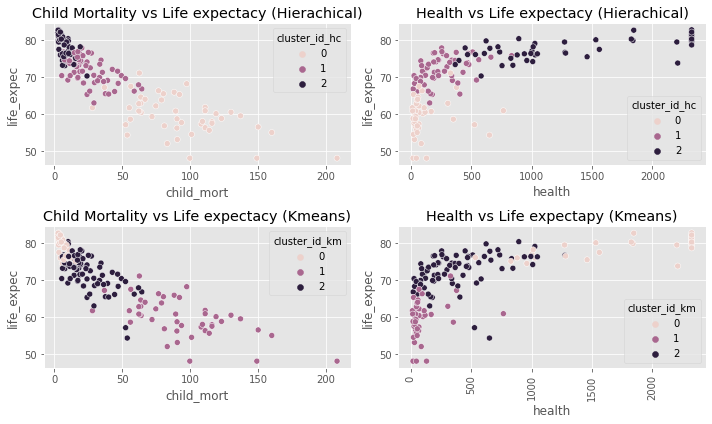

In [12]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(2, 2, 1, title="Child Mortality vs Life expectacy (Hierachical)")
ax3 = fig.add_subplot(2, 2, 3, title="Child Mortality vs Life expectacy (Kmeans)")
ax2 = fig.add_subplot(2, 2, 2, title="Health vs Life expectacy (Hierachical)")
ax4 = fig.add_subplot(2, 2, 4, title="Health vs Life expectapy (Kmeans)")

sns.scatterplot(country_df_clustered['child_mort'],country_df_clustered['life_expec'],hue=country_df_clustered['cluster_id_hc'],ax=ax1)
sns.scatterplot(country_df_clustered['child_mort'],country_df_clustered['life_expec'],hue=country_df_clustered['cluster_id_km'],ax=ax3)
sns.scatterplot(country_df_clustered['health'],country_df_clustered['life_expec'],hue=country_df_clustered['cluster_id_hc'],ax=ax2)
sns.scatterplot(country_df_clustered['health'],country_df_clustered['life_expec'],hue=country_df_clustered['cluster_id_km'],ax=ax4)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
# Under - developed countries obtained from both the model
country_df_clustered[(country_df_clustered['cluster_id_hc'] == 0) | (country_df_clustered['cluster_id_km'] == 1)].sort_values(by=['gdpp','income','child_mort'], ascending=['True','True','False'])[['country','cluster_id_hc','cluster_id_km']]

,country,cluster_id_hc,cluster_id_km
26,Burundi,0,1
88,Liberia,0,1
37,"Congo, Dem. Rep.",0,1
112,Niger,0,1
132,Sierra Leone,0,1
93,Madagascar,0,1
106,Mozambique,0,1
31,Central African Republic,0,1
94,Malawi,0,1
50,Eritrea,0,1


In [12]:
# Final list of under-developed countries, in order of socio-economic condition from from worst to better
country_df_clustered[(country_df_clustered['cluster_id_hc'] == 0)].sort_values(by=['gdpp','income','child_mort'],ascending=['True','True','False'])[['country']].head(15)

,country
26,Burundi
88,Liberia
37,"Congo, Dem. Rep."
112,Niger
132,Sierra Leone
93,Madagascar
106,Mozambique
31,Central African Republic
94,Malawi
50,Eritrea
